In [ ]:
import pandas as pd
from IPython.display import display
import numpy as np

data = pd.read_parquet('/content/drive/MyDrive/Dados/dados_agregados_2.parquet')
data

In [ ]:
display(data['Intencao'].value_counts())

print(f"\nIntenções únicas: {len(data['Intencao'].unique())}")

,count
Intencao,
Confirmacao de cambio/taxas,238
"Pedido de envio via metodo ""ByPhone""",133
Como se inscrever,128
Tempo de remessa,69
Registro/Atualizacao de Documento,64
Cadastro de beneficiario,51
Termos e condicoes do servico,48
Problemas de remessa,44
Como depositar,42



Intenções únicas: 19


In [ ]:
data[data['Intencao'] == 'Confirmacao de cambio/taxas']

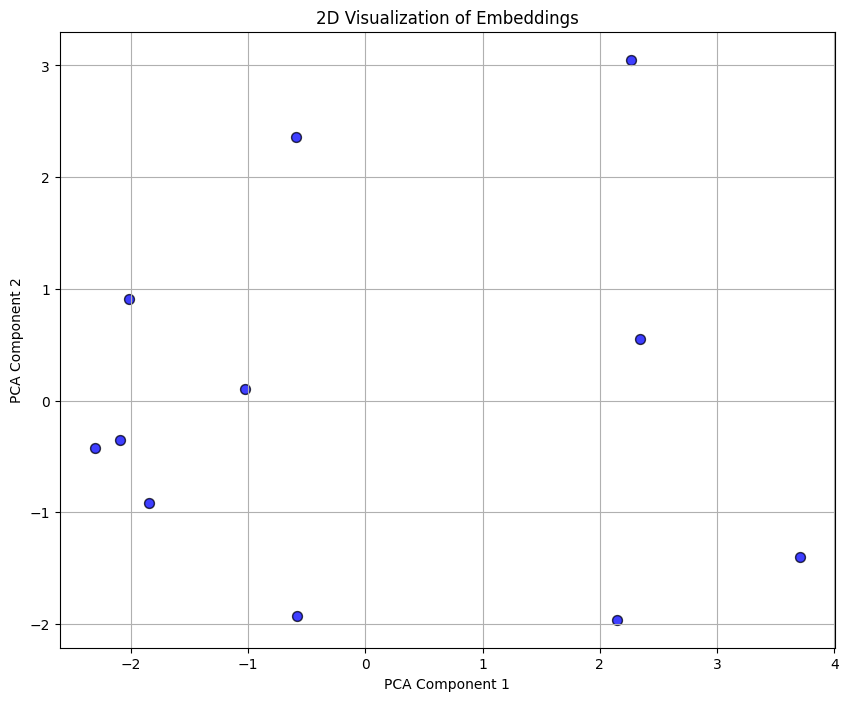

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your original DataFrame is loaded as 'data' and has the mentioned structure
# Convert string embeddings to numpy arrays

chosen_column = 'Reembolso' # @param {type:"string"}

# Filter the data for a specific intention
test_df = data[data['Intencao'] == chosen_column]

# Stack the list of numpy arrays into a 2D numpy array
embeddings = np.stack(test_df['perguntas_embedding'].values)

# Calculate pairwise Euclidean distances
distances = pairwise_distances(embeddings, metric='euclidean')

# Dimensionality reduction with PCA to 2D for plotting
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plotting the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', edgecolors='k', s=50, alpha=0.5)
plt.title('2D Visualization of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


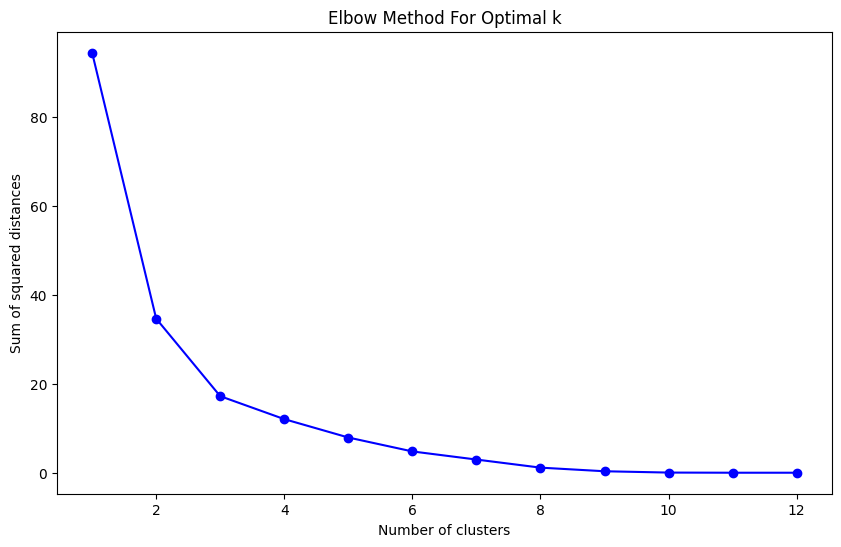

Optimal k value: 7


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming embeddings_2d contains your 2D PCA results
# Ensure unique data points only, since duplicates don't contribute to new clusters
unique_points = np.unique(embeddings_2d, axis=0)
num_unique_points = unique_points.shape[0]

# Adjusting the maximum range for k to the number of unique points minus one
K = range(1, num_unique_points)  # Set range to 1 to the number of unique points

ssd = []  # Sum of squared distances of samples to their closest cluster center

for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    km = km.fit(unique_points)  # Fit to unique points only
    ssd.append(km.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Finding the elbow point
def find_elbow(K, ssd):
    # Transform list into array
    ssd = np.array(ssd)
    gradients = np.diff(ssd)  # Calculate the gradient between each point
    # Calculate second derivative
    second_derivatives = np.diff(gradients)
    # The elbow is typically at the point of maximum curvature (or minimum in this second derivative)
    elbow_point = np.argmin(second_derivatives) + 2  # +2 because np.diff reduces the original index by 1 each time
    return elbow_point

optimal_k = find_elbow(K, ssd)
print("Optimal k value:", optimal_k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


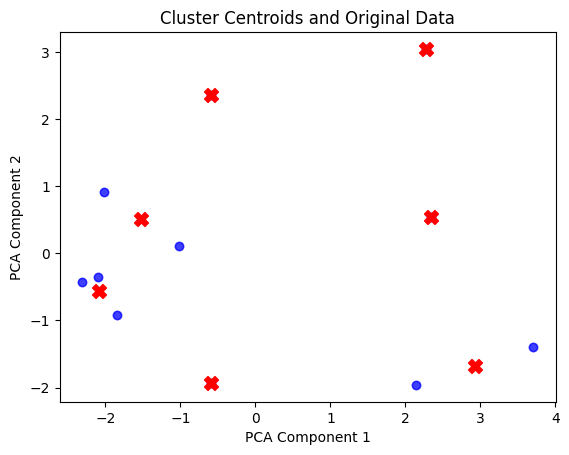

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming embeddings_2d contains your 2D PCA results
k = optimal_k  # Adjust this based on your preference or Elbow method
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings_2d)

# Get centroids
centroids = kmeans.cluster_centers_

# Plotting original points
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5)

# Plotting centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')  # Centroids in red
plt.title('Cluster Centroids and Original Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


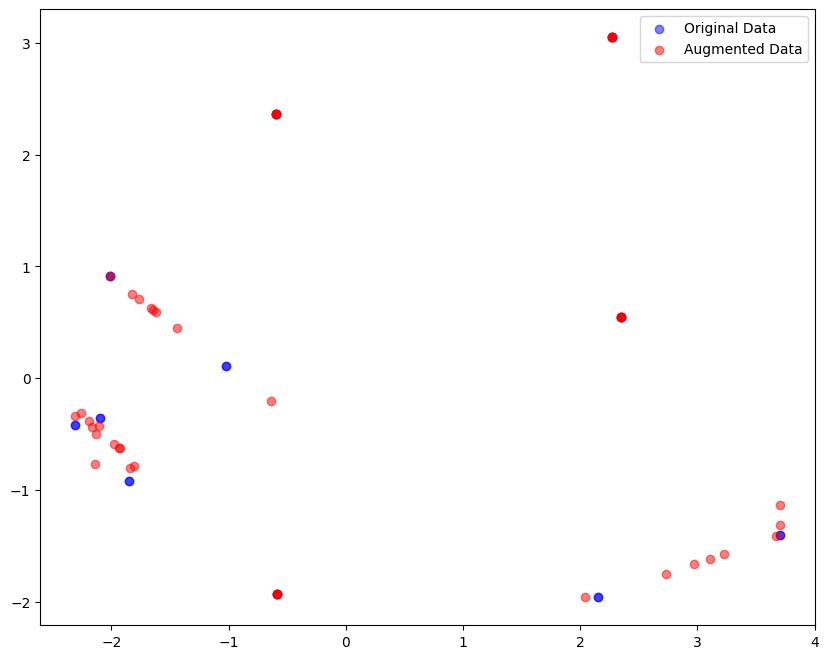

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Assuming embeddings_2d contains your 2D PCA results and optimal_k is defined
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(embeddings_2d)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

augmented_data = []

# Augment data using Gaussian distributions around each cluster
for i in range(optimal_k):
    points = embeddings_2d[labels == i]
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)
    # Generate new points based on a Gaussian distribution
    gaussian_points = np.random.multivariate_normal(mean, cov, size=len(points) * 2)  # Generate twice as many points
    augmented_data.extend(gaussian_points)

augmented_data = np.array(augmented_data)

# Ensure new points stay within plausible bounds (optional clipping or bounding)
min_bounds = np.min(embeddings_2d, axis=0)
max_bounds = np.max(embeddings_2d, axis=0)
augmented_data = np.clip(augmented_data, min_bounds, max_bounds)

# Plotting original data and augmented data
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5, label='Original Data')
plt.scatter(augmented_data[:, 0], augmented_data[:, 1], c='red', alpha=0.5, label='Augmented Data')
plt.legend()
plt.show()


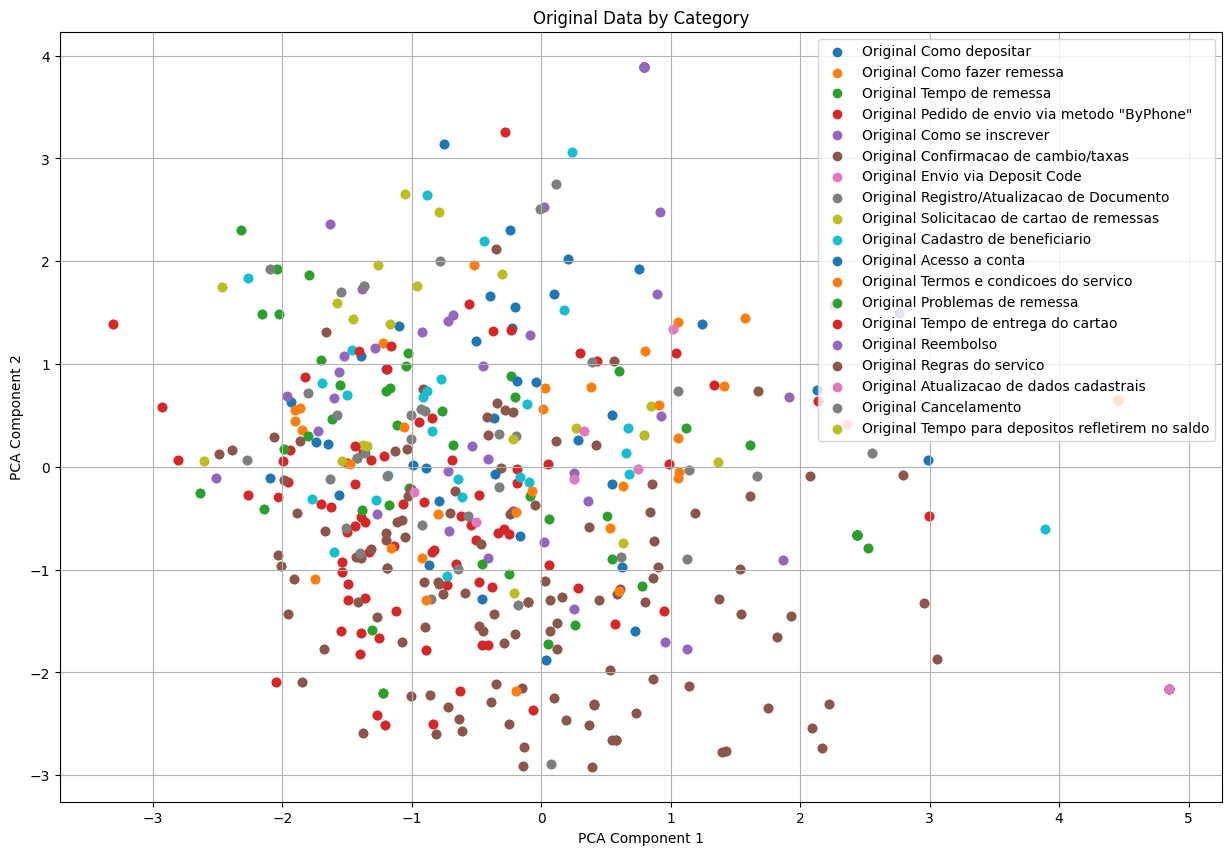

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

pca = PCA(n_components=2)
data['embeddings_2d'] = list(pca.fit_transform(list(data['perguntas_embedding'])))

categories = data['Intencao'].unique()
all_augmented_data = []

plt.figure(figsize=(15, 10))
for category in categories:
    cat_data = data[data['Intencao'] == category]
    embeddings_2d = np.vstack(cat_data['embeddings_2d'])
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], label=f'Original {category}')
plt.title('Original Data by Category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


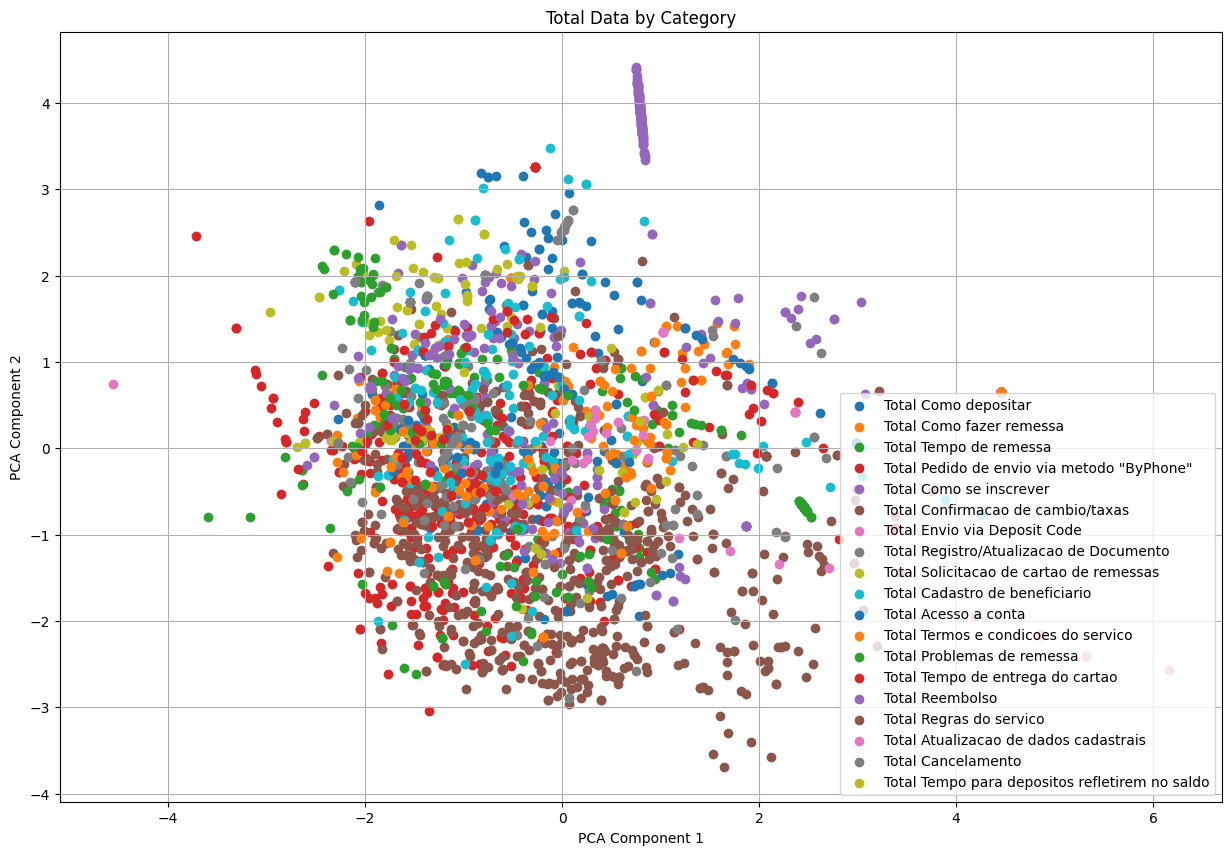

In [ ]:
plt.figure(figsize=(15, 10))
for category in categories:
    cat_data = data[data['Intencao'] == category]
    embeddings_2d = np.vstack(cat_data['embeddings_2d'])
    unique_embeddings = np.unique(embeddings_2d, axis=0)

    max_clusters = min(len(unique_embeddings), 15)
    if max_clusters > 1:
        K = range(1, max_clusters)
        ssd = [KMeans(n_clusters=k, n_init='auto', random_state=0).fit(unique_embeddings).inertia_ for k in K]

        if len(ssd) > 1:
            gradients = np.diff(ssd)
            second_derivatives = np.diff(gradients)
            optimal_k = np.argmin(second_derivatives) + 2 if len(second_derivatives) > 0 else 1
        else:
            optimal_k = 1
    else:
        optimal_k = 1

    kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=0).fit(embeddings_2d)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    augmented_data = []
    for i in range(optimal_k):
        points = embeddings_2d[labels == i]
        if len(points) > 1:
            mean = np.mean(points, axis=0)
            cov = np.cov(points, rowvar=False)
            try:
                gaussian_points = np.random.multivariate_normal(mean, cov, size=len(points) * 2)
                augmented_data.extend(gaussian_points)
            except np.linalg.LinAlgError:
                print(f"Skipping cluster {i} due to singular covariance matrix.")

    augmented_data = np.array(augmented_data)

    total_data = np.vstack([embeddings_2d, augmented_data]) if augmented_data.size > 0 else embeddings_2d
    plt.scatter(total_data[:, 0], total_data[:, 1], label=f'Total {category}')

plt.title('Total Data by Category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

Unique data points in original embeddings: 431
Explained variance by each component: [1.11980917e-01 9.49926984e-02 5.43410596e-02 4.95981910e-02
 4.28272642e-02 3.60954454e-02 3.43720769e-02 2.67896087e-02
 2.63451367e-02 2.20652018e-02 2.00018436e-02 1.80598661e-02
 1.56040475e-02 1.40419979e-02 1.36749011e-02 1.32825382e-02
 1.24855526e-02 1.10676221e-02 1.01835548e-02 9.23376394e-03
 9.07862827e-03 8.65136735e-03 8.23486846e-03 8.08177509e-03
 7.95316081e-03 7.51381345e-03 6.89366860e-03 6.40611448e-03
 6.33892859e-03 6.28628990e-03 6.16060716e-03 5.97631404e-03
 5.69747083e-03 5.35821079e-03 5.23386685e-03 5.04095765e-03
 4.93652768e-03 4.87196724e-03 4.70231584e-03 4.46143752e-03
 4.33071823e-03 4.28080430e-03 4.06482410e-03 3.98355717e-03
 3.85842169e-03 3.71043487e-03 3.57032831e-03 3.52695913e-03
 3.47934730e-03 3.42304380e-03 3.32389420e-03 3.25153375e-03
 3.17099930e-03 3.09833170e-03 3.08088286e-03 2.99080149e-03
 2.93245143e-03 2.88045647e-03 2.86725336e-03 2.76708154e-03


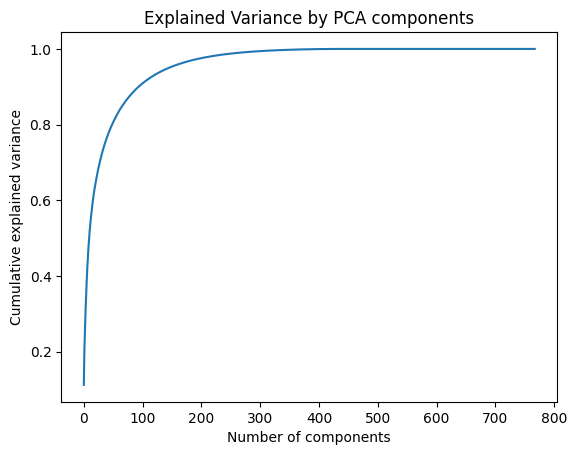

PCA reduced embeddings: [[-0.45982842 -1.28973172]
 [ 4.45410137  0.65270991]
 [ 2.43847417 -0.65825345]
 ...
 [-0.78402109  2.00390328]
 [-0.53804908  0.20487475]
 [-2.15501671  1.48684985]]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'data' is your DataFrame and it has a column 'perguntas_embedding' which holds the embedding vectors
perguntas_embedding = np.vstack(data['perguntas_embedding'])  # Convert list of embeddings into a numpy array

# Check the number of unique data points
unique_embeddings = np.unique(perguntas_embedding, axis=0)
print("Unique data points in original embeddings:", unique_embeddings.shape[0])

# Applying PCA to check explained variance without immediately reducing dimensions
pca_full = PCA()
pca_full.fit(perguntas_embedding)
explained_variance = pca_full.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)

# Plot cumulative explained variance to see how many components might be needed
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained Variance by PCA components')
plt.show()

# If PCA shows some variance, try reducing to a higher dimension than 2
if explained_variance[0] > 0:  # Check if the first component explains any variance
    pca = PCA(n_components=2)  # You can adjust this to 3 or more if needed
    embeddings_2d = pca.fit_transform(perguntas_embedding)
    print("PCA reduced embeddings:", embeddings_2d)
else:
    print("No variance to capture with PCA. Check your input data for variability.")


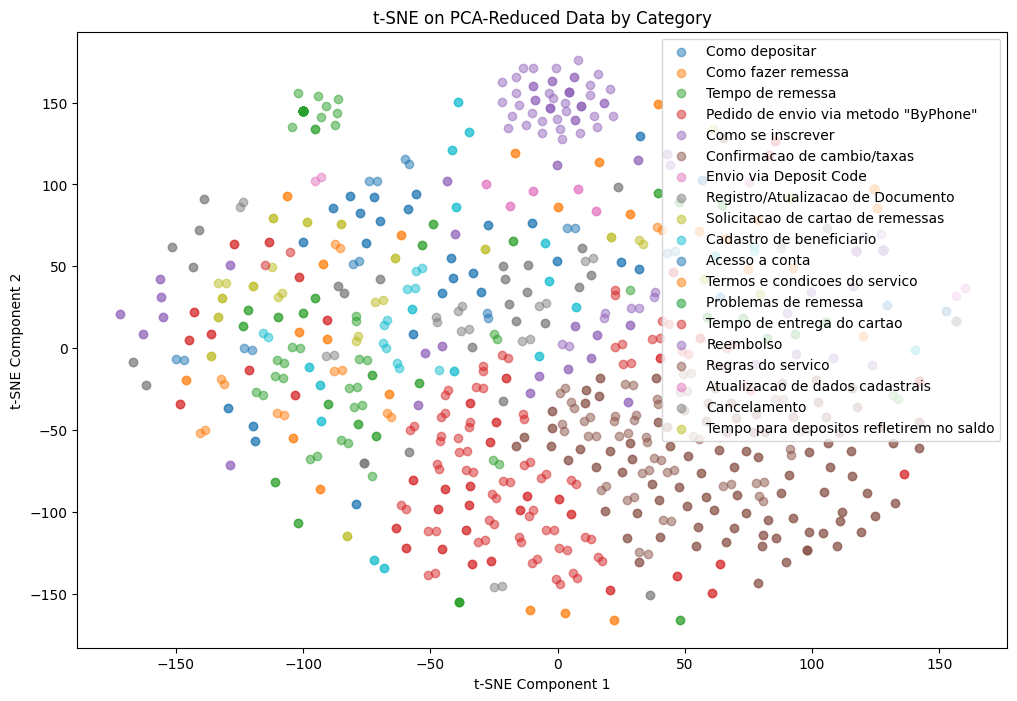

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


# Assume 'embeddings' is a matrix of embedding vectors and 'Intencao' is the category labels
embeddings = np.array(data['perguntas_embedding'].tolist())  # Ensure it's correctly formatted as a 2D NumPy array
category_counts = data['Intencao'].value_counts()

inverse_frequency = 1 / category_counts
weights = inverse_frequency.reindex(data['Intencao']).fillna(0).values

# If embeddings are not normalized, uncomment the next two lines:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Apply weights
embeddings_weighted = embeddings * np.sqrt(weights[:, np.newaxis])

# After PCA reduction
pca = PCA(n_components=0.95)
embeddings_reduced = pca.fit_transform(embeddings_weighted)

# Apply t-SNE to the PCA-reduced data for better visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_reduced)

plt.figure(figsize=(12, 8))
for category in categories:
    category_mask = data['Intencao'] == category
    plt.scatter(embeddings_tsne[category_mask, 0], embeddings_tsne[category_mask, 1], alpha=0.5, label=category)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on PCA-Reduced Data by Category')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


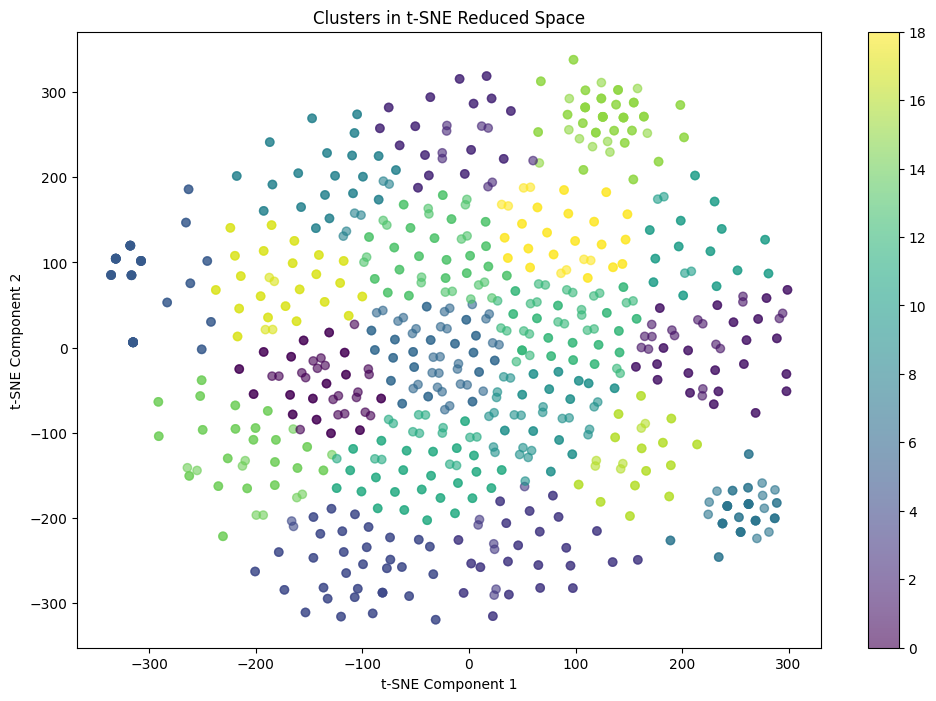

Cluster-Category Cross-Tabulation:
Intencao  Acesso a conta  Atualizacao de dados cadastrais  \
row_0                                                       
0                      0                                0   
1                      0                                0   
2                     10                                4   
3                      0                                0   
4                      0                                0   
5                      2                                2   
6                      2                                0   
7                      0                                0   
8                     10                                6   
9                      0                                0   
10                     0                                0   
11                     0                                0   
12                     2                                0   
13                     4                          

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'embeddings' is already loaded and preprocessed
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# First apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# Now apply a clustering algorithm on the t-SNE output
kmeans = KMeans(n_clusters=len(np.unique(data['Intencao'])), random_state=42)
clusters = kmeans.fit_predict(embeddings_tsne)

# Plot the clustered data
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('Clusters in t-SNE Reduced Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

cluster_category_table = pd.crosstab(clusters, category_labels)

# Print the table
print("Cluster-Category Cross-Tabulation:")
print(cluster_category_table)

# Analyzing the cross-tabulation for insights
print("\nCluster Purity Analysis:")
for cluster in cluster_category_table.index:
    total_count = cluster_category_table.loc[cluster].sum()
    max_count = cluster_category_table.loc[cluster].max()
    purity = max_count / total_count
    dominant_category = cluster_category_table.loc[cluster].idxmax()
    print(f"Cluster {cluster}: Most dominant category = {dominant_category} with purity = {purity:.2f}")

# Overall purity
overall_purity = sum(cluster_category_table.max(axis=1)) / cluster_category_table.sum().sum()
print(f"\nOverall Purity of Clustering: {overall_purity:.2f}")



In [ ]:
# Assuming the initial setup and embeddings processing as you described
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def perform_tsne_pca_clustering(data, num_components=50, perplexity=30, learning_rate=200):
    # Standard scaling
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # PCA reduction
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(scaled_data)

    # t-SNE reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate)
    tsne_result = tsne.fit_transform(pca_result)

    # Clustering
    kmeans = KMeans(n_clusters=len(np.unique(category_labels)), random_state=42)
    clusters = kmeans.fit_predict(tsne_result)

    return clusters, tsne_result

# Main loop for iterative refinement
def cluster_refinement(embeddings, category_labels, purity_threshold=0.8):
    locked_clusters = {}
    available_data = embeddings.copy()
    iteration = 0

    while True:
        clusters, tsne_result = perform_tsne_pca_clustering(available_data)
        cluster_purity, dominant_categories = calculate_cluster_purity(clusters, category_labels)

        # Lock clusters with high purity
        for cluster_id, purity in cluster_purity.items():
            if purity > purity_threshold and dominant_categories[cluster_id] not in locked_clusters:
                locked_clusters[dominant_categories[cluster_id]] = cluster_id

        # Check if all categories are locked or no significant changes
        if len(locked_clusters) == len(np.unique(category_labels)) or iteration > 10:
            break

        # Exclude data points that belong to locked clusters
        available_data = exclude_locked_data(embeddings, clusters, locked_clusters)
        iteration += 1

    return locked_clusters

def calculate_cluster_purity(clusters, category_labels):
    # Create a cross-tabulation of clusters and categories
    cross_tab = pd.crosstab(clusters, category_labels)

    # Calculate purity for each cluster
    total_counts = cross_tab.sum(axis=1)
    max_counts = cross_tab.max(axis=1)
    purity = max_counts / total_counts

    # Find dominant categories for each cluster
    # Ensure that we handle cases where categories may not be in the index
    dominant_categories = cross_tab.idxmax(axis=1)
    valid_categories = {i: cat for i, cat in dominant_categories.items() if cat in category_labels.values}

    return purity, valid_categories

def exclude_locked_data(data, clusters, locked_clusters, category_labels):
    # Determine which clusters are locked and should be excluded from the dataset
    exclusion_mask = np.isin(clusters, list(locked_clusters.values()))

    # Filter data, clusters, and labels
    remaining_data = data[~exclusion_mask]
    remaining_clusters = clusters[~exclusion_mask]
    remaining_labels = category_labels[~exclusion_mask]

    return remaining_data, remaining_clusters, remaining_labels


# Load and preprocess embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Initial clustering using t-SNE and KMeans
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)
kmeans = KMeans(n_clusters=len(np.unique(data['Intencao'])), random_state=42)
clusters = kmeans.fit_predict(embeddings_tsne)

# Initial cluster purity calculation
purity, dominant_categories = calculate_cluster_purity(clusters, data['Intencao'])

locked_clusters = {}
available_data = embeddings_scaled.copy()
available_clusters = clusters.copy()
available_labels = data['Intencao'].copy()

iteration = 0
while True:
    # Calculate cluster purity and get dominant categories
    cluster_purity, dominant_categories = calculate_cluster_purity(available_clusters, available_labels)

    # Lock clusters with high purity
    for cluster_id, purity in cluster_purity.items():
        category = dominant_categories.get(cluster_id)
        if purity > 0.8 and category not in locked_clusters:
            locked_clusters[category] = cluster_id

    # Check if all categories are locked or if no significant changes
    if len(locked_clusters) >= len(np.unique(data['Intencao'])) or iteration > 10:
        break

    # Exclude data points that belong to locked clusters
    available_data, available_clusters, available_labels = exclude_locked_data(embeddings_scaled, available_clusters, locked_clusters, available_labels)
    if available_data.size == 0:
        break

    # Reapply clustering to remaining data
    tsne_result = tsne.fit_transform(available_data)
    available_clusters = kmeans.fit_predict(tsne_result)

    iteration += 1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1002 but corresponding boolean dimension is 899

# Teste com modelo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Bidirectional
from keras.optimizers import Adam

# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_categories_labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(all_augmented_data, y_encoded, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

# Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate the model
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Predict and generate a classification report
y_pred = model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=-1)
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, zero_division=1)
print(report)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2546 - loss: 2.7768 - val_accuracy: 0.3364 - val_loss: 2.2458
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3000 - loss: 2.2686 - val_accuracy: 0.3458 - val_loss: 2.0983
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3499 - loss: 2.0778 - val_accuracy: 0.3676 - val_loss: 2.0503
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3667 - loss: 2.1165 - val_accuracy: 0.3707 - val_loss: 2.0040
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3764 - loss: 2.0021 - val_accuracy: 0.3707 - val_loss: 1.9699
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3814 - loss: 1.9994 - val_accuracy: 0.3645 - val_loss: 1.9562
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3496 - loss: 1.9814 - val_accuracy: 0.3614 - val_loss: 1.9366
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3976 - loss: 1.9327 - val_accuracy: 0.3489 -